# Where do the water masses go in the Salish Sea?
Using the same water mass seperations as in Thomson 2007

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.stats import pearsonr
import datetime as dt

import cmocean as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from dateutil.relativedelta import relativedelta
import math
from matplotlib.gridspec import GridSpec
%matplotlib inline

plt.rcParams['font.size'] = 12

In [2]:
d = 150

In [3]:
# round to 2 sig fig
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

In [4]:
def get_data(mydata, starttime, endtime, time):
    salt = mydata.init_salt[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
#     temp = mydata.init_t[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    init_depth = depthf(mydata.init_z[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    depth = depthf(mydata.final_z[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    section = mydata.final_section[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    trans = mydata.final_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(time)
    init_trans = mydata.init_transp[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]/(time)
    lons = mydata.final_lon[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    init_time = mydata.init_t[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    final_time = mydata.final_t[(mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    
    return salt, depth, init_depth, section, trans, init_trans, lons, init_time, final_time

In [5]:
# section numbers
meander = 0
admiralty = 2
deception = 3
rosario = 4
sanjuan = 5
haro = 6
sec_name = ['meander', 'admiralty', 'deception', 'rosario', 'sanjuan', 'haro']

In [6]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [7]:
def draw_patches(fmask, ll, ul, u_lons, w_depths):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='lightgray')
    return(pc)

In [8]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
CSadmiralty = [2, 255, 267, 204, 300]
CSrosario = [4, 286, 307, 266, 300]
CSsanjuan = [5, 264, 266, 280, 300]
CSharo = [6, 218, 242, 304, 300]
CSjdf = [0, 18, 63, 377, 300]

#in the format [section, jgridS, jgridN, figrid, maxdepth]
CSdecep = [3, 246, 247, 309, 300]

In [9]:
def FluxCS(lonW, lonE, figrid, maxdepth, ax, lons, depths, transports, high, salfile, distlabel, bar, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    
    f_lons = mymesh.glamf[0, igrid]
    u_lons = mymesh.glamv[0, igrid]
    w_depths = mymesh.gdepw_1d
    gridding=1
    
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mymesh.e2f[0, igrid, lonW:lonE].sum())).values
    f_dist = f_lons/m2lon
    
    dist = lons/m2lon
    vmax = high/np.sum(transports)/m2lon
    
    cmap = cm.cm.speed
    cmap.set_under('white')
    vmin = 0.0000000001
    
    H, xedges, yedges, im = ax.hist2d(lons, depths, bins=[np.array(f_lons[lonW-1:lonE:gridding]), w_depths[0]],weights= transports, cmap=cmap, vmin=vmin, vmax=vmax, density= True)
    
#     H = np.where(H>0, H, H*np.nan)
    if bar == True:
        cb1 = fig.colorbar(im, ax=ax)
        cb1.set_ticks([0, vmax])
        cb1.set_ticklabels([0, high])
        cb1.set_label('$m^3 \, s^{-1} m^{-2}$', labelpad=-20, fontsize=14)
    
    xs, ys = np.meshgrid(np.array(f_lons[lonW-1:lonE+1]), np.array(w_depths[0]))
    salinity = 0.5*(np.ma.array(salfile.vosaline[0, :, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.vosaline[0, :, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12, fmt='%1.0f')
    
    if distlabel == True:
        distance = abs(round_to_2((f_dist[lonW-1]-f_dist[lonE+1]).values/1000))
        ax.set_xlabel("Cross-section width = "+str(distance)[:-2]+" km", fontsize=14)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(u_lons), np.array(w_depths[0]))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([u_lons[lonW+1], u_lons[lonE-1]])
    ax.set_ylabel('Depth [m]', fontsize=14)
    ax.set_xticklabels(np.round([u_lons[lonW+1], u_lons[lonE-1]],2))
    ax.set_xlim((u_lons[lonW-2], u_lons[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title), fontsize=16)
    mydata.close()

In [10]:
path = "/results/SalishSea/month-avg.201905/"
salS17 = xr.open_dataset(path+"SalishSea_1m_201708_201708_grid_T.nc")
salW17 = xr.open_dataset(path+"SalishSea_1m_201801_201801_grid_T.nc")
salW16 = xr.open_dataset(path+"SalishSea_1m_201701_201701_grid_T.nc")

## summer 2017

In [11]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
sum_start = 1+(5*720+(sum(yearjumps[:5+1]*24)))
sum_end = 720+(8*720+(sum(yearjumps[:8+1]*24)))

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, depth, init_depth, section, trans, init_trans, lons, init_time, final_time = get_data(mydata, sum_start, sum_end, sum_end-sum_start+1)

In [12]:
d = {'salt': salt, 'depth':depth, 'init_depth':init_depth, 'section':section, 'transport':trans, 'init_transport':init_trans, 'lon':lons, 'init_time':init_time, 'final_time':final_time}
dfS = pd.DataFrame(data=d)

In [71]:
upwelled = dfS[(dfS.init_depth <= d) & (dfS.salt >= 32)]
cuc = dfS[(dfS.init_depth > d) & (dfS.salt >= 32)]
columbia = dfS[(dfS.init_depth <= d) & (dfS.salt < 32)]

In [72]:
loop = dfS[(dfS.section == meander) & (abs(dfS.final_time-dfS.init_time) > 24)]
total_tr = np.sum([np.sum(dfS.transport[dfS.section==haro]),np.sum(dfS.transport[dfS.section==sanjuan]),np.sum(dfS.transport[dfS.section==rosario]),
           np.sum(dfS.transport[dfS.section==admiralty]),np.sum(dfS.transport[dfS.section==deception]),
           np.sum(dfS.transport[(dfS.section == meander) & (abs(dfS.final_time-dfS.init_time) > 24)])])
np.sum(loop.transport)/total_tr*100

45.54303238505798

In [73]:
[np.sum(upwelled.transport)/np.sum(dfS.transport)*100,np.sum(cuc.transport)/np.sum(dfS.transport)*100,
np.sum(columbia.transport)/np.sum(dfS.transport)*100]

[62.73457441328111, 26.019735476696415, 11.245690110022469]

In [74]:
# lets see what sections these groups get into 
# first upwelled
tide = 24
tottran = np.sum(upwelled.transport) - np.sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time <= tide)])
print('tidally pumped = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time <= tide)])/np.sum(upwelled.transport)*100))
print('entrained and advects back out = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time > tide)])/tottran*100))
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/tottran*100))
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/tottran*100))
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/tottran*100))
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/tottran*100))
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/tottran*100))
print('\n')
print('tidally pumped = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time <= tide)])/10000) + ' mSv')
print('entrained and advects back out = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time > tide)])/10000) + ' mSv')
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/10000) + ' mSv')
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/10000) + ' mSv')
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/10000) + ' mSv')
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/10000) + ' mSv')
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/10000) + ' mSv')

tidally pumped = 60.70950566572726
entrained and advects back out = 41.11209220167632
haro = 41.51101861134296
sanjuan = 2.2568373064027205
rosario = 4.701954587184183
admiralty = 10.366113834711292
deception = 0.051683930574277274


tidally pumped = 20.312679652852772 mSv
entrained and advects back out = 5.404650245209779 mSv
haro = 5.457093640871788 mSv
sanjuan = 0.2966868297923962 mSv
rosario = 0.6181251950868621 mSv
admiralty = 1.3627430928061715 mSv
deception = 0.0067944381590067365 mSv


In [75]:
# and deep
tottran = np.sum(cuc.transport) - np.sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time <= tide)])
print('tidally pumped = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time <= tide)])/np.sum(cuc.transport)*100))
print('entrained and advects back out = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time > tide)])/tottran*100))
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/tottran*100))
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/tottran*100))
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/tottran*100))
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/tottran*100))
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/tottran*100))
print('\n')
print('tidally pumped = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time <= tide)])/10000) + 'mSv')
print('entrained and advects back out = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time > tide)])/10000) + 'mSv')
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/10000) + 'mSv')
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/10000) + 'mSv')
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/10000) + 'mSv')
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/10000) + 'mSv')
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/10000) + 'mSv')

tidally pumped = 67.82401623936013
entrained and advects back out = 56.47337146250637
haro = 32.37550004307403
sanjuan = 1.6030163286433257
rosario = 3.199710371844941
admiralty = 6.322249166755989
deception = 0.0261526271758166


tidally pumped = 9.41217399457753mSv
entrained and advects back out = 2.5216336642771946mSv
haro = 1.4456220461465603mSv
sanjuan = 0.07157745029224512mSv
rosario = 0.1428725996098518mSv
admiralty = 0.28229935489905666mSv
deception = 0.0011677600148171303mSv


In [76]:
# columbia 
tottran = np.sum(columbia.transport) - np.sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time <= tide)])
print('tidally pumped = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time <= tide)])/np.sum(columbia.transport)*100))
print('entrained and advects back out = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time > tide)])/tottran*100))
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/tottran*100))
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/tottran*100))
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/tottran*100))
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/tottran*100))
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/tottran*100))
print('\n')
print('tidally pumped = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time <= tide)])/10000)+' mSv')
print('entrained and advects back out = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time > tide)])/10000)+' mSv')
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/10000)+' mSv')
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/10000)+' mSv')
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/10000)+' mSv')
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/10000)+' mSv')
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/10000)+' mSv')

tidally pumped = 96.9769582761939
entrained and advects back out = 97.61858828222665
haro = 1.4526550134701242
sanjuan = 0.06352734541175876
rosario = 0.2217638263128684
admiralty = 0.6434655325779592
deception = 0.0


tidally pumped = 5.816453180944503 mSv
entrained and advects back out = 0.17699717818008318 mSv
haro = 0.0026338819560677417 mSv
sanjuan = 0.00011518462900369531 mSv
rosario = 0.0004020911608178038 mSv
admiralty = 0.0011666997600208006 mSv
deception = 0.0 mSv


In [77]:
time = 720*4
distlabel= False

In [78]:
time = sum_end-sum_start+1
time

2928

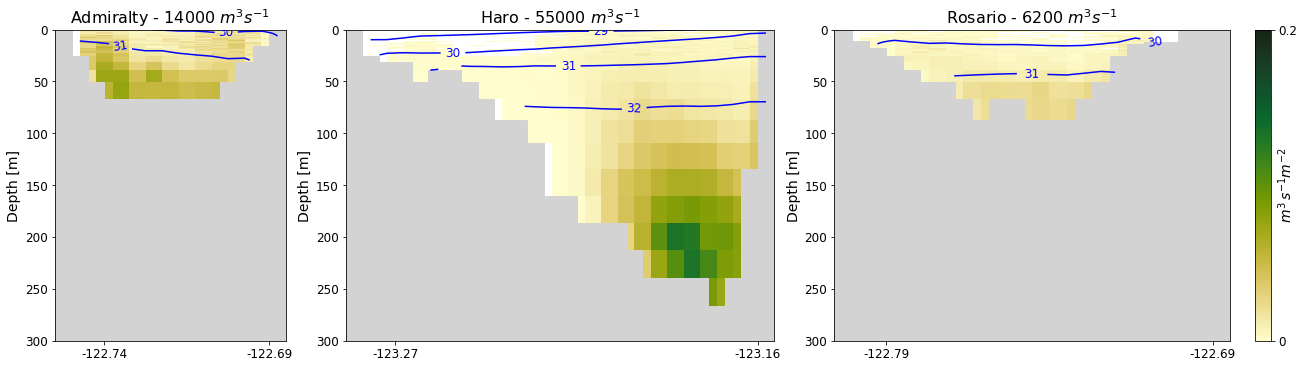

In [79]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 32, figure=fig)
ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:20])
ax2 = fig.add_subplot(gs[0, 20:])

high = 0.2
title = "Admiralty - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(upwelled.lon[upwelled.section == admiralty]), np.array(upwelled.depth[upwelled.section == admiralty]), np.array(upwelled.transport[upwelled.section == admiralty]), high, salS17, distlabel, False, title)
title = "Haro - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(upwelled.lon[upwelled.section == haro]), np.array(upwelled.depth[upwelled.section == haro]), np.array(upwelled.transport[upwelled.section == haro]), high, salS17, distlabel, False, title)
title = "Rosario - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(upwelled.lon[upwelled.section == rosario]), np.array(upwelled.depth[upwelled.section == rosario]), np.array(upwelled.transport[upwelled.section == rosario]), high, salS17, distlabel, True, title)

plt.savefig("./figures/InterChannelS17.pdf")

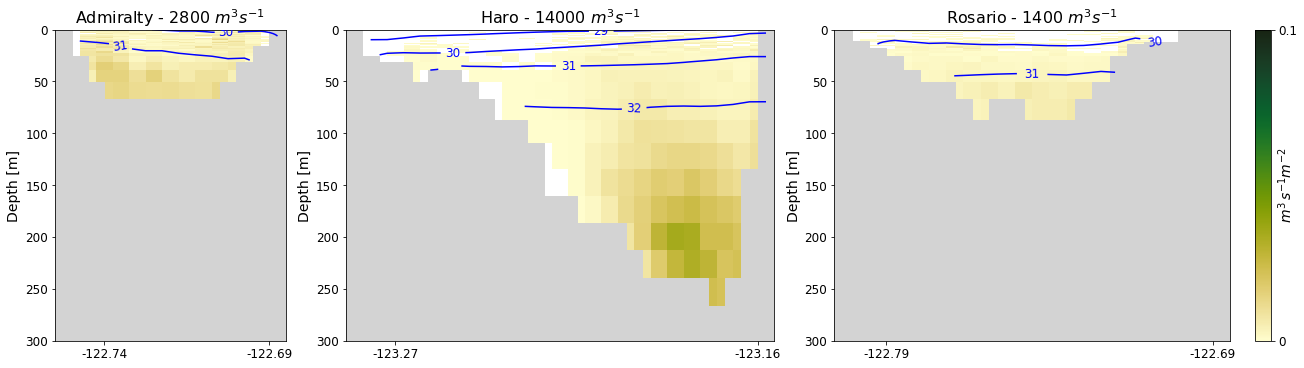

In [82]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 32, figure=fig)
ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:20])
ax2 = fig.add_subplot(gs[0, 20:])

high = 0.1
title = "Admiralty - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(cuc.lon[cuc.section == admiralty]), np.array(cuc.depth[cuc.section == admiralty]), np.array(cuc.transport[cuc.section == admiralty]), high, salS17, distlabel, False, title)
title = "Haro - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(cuc.lon[cuc.section == haro]), np.array(cuc.depth[cuc.section == haro]), np.array(cuc.transport[cuc.section == haro]), high, salS17, distlabel, False, title)
title = "Rosario - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(cuc.lon[cuc.section == rosario]), np.array(cuc.depth[cuc.section == rosario]), np.array(cuc.transport[cuc.section == rosario]), high, salS17, distlabel, True, title)

plt.savefig("./figures/DeepChannelS17.pdf")

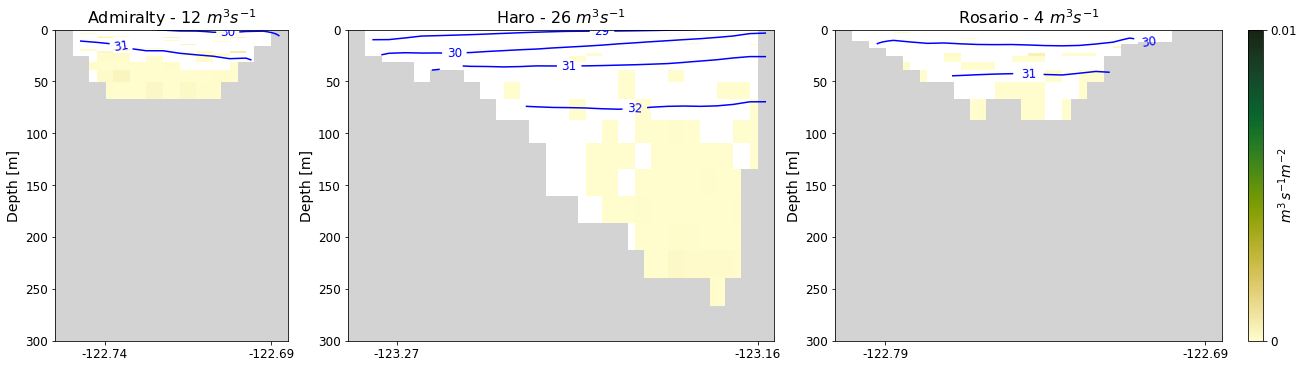

In [83]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 27, figure=fig)
ax0 = fig.add_subplot(gs[0, :6])
ax1 = fig.add_subplot(gs[0, 6:17])
ax2 = fig.add_subplot(gs[0, 17:27])

high = 0.01
title = "Admiralty - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(columbia.lon[columbia.section == admiralty]), np.array(columbia.depth[columbia.section == admiralty]), np.array(columbia.transport[columbia.section == admiralty]), high, salS17, distlabel, False, title)
title = "Haro - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(columbia.lon[columbia.section == haro]), np.array(columbia.depth[columbia.section == haro]), np.array(columbia.transport[columbia.section == haro]), high, salS17, distlabel, False, title)
title = "Rosario - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(columbia.lon[columbia.section == rosario]), np.array(columbia.depth[columbia.section == rosario]), np.array(columbia.transport[columbia.section == rosario]), high, salS17, distlabel, True, title)

plt.savefig("./figures/PlumeChannelS17.pdf")

## Winter 2016/17

In [24]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
win_start1 = 1+(9*720+(sum(yearjumps[:9+1]*24)))
win_end1 = 720+(11*720+(sum(yearjumps[:11+1]*24)))

win_start2 = 1+(0*720+(sum(yearjumps[:0+1]*24)))
win_end2 = 720+(5*720+(sum(yearjumps[:5+1]*24)))

time = (win_end1-win_start1+1) + (win_end2-win_start2+1)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW, depthW, init_depthW, sectionW, transW, init_transW, lonsW, init_tW, final_tW = get_data(mydata, win_start1, win_end1, time)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS, depthS, init_depthS, sectionS, transS, init_transS, lonsS, init_tS, final_tS = get_data(mydata, win_start2, win_end2, time)

salt = np.append(saltW, saltS)
# temp = np.append(tempW, tempS)
depth = np.append(depthW, depthS)
init_depth = np.append(init_depthW, init_depthS)
section = np.append(sectionW, sectionS)
trans = np.append(transW, transS)
init_trans = np.append(init_transW, init_transS)
lons = np.append(lonsW, lonsS)
iniT = np.append(init_tW, init_tS)
finT = np.append(final_tW, final_tS)

In [25]:
d = {'salt': salt, 'depth':depth, 'init_depth':init_depth, 'section':section, 'transport':trans, 'init_transport':init_trans, 'lon':lons, 'init_time':iniT, 'final_time':finT}
dfW16 = pd.DataFrame(data=d)

In [84]:
upwelled = dfW16[(dfW16.init_depth <= d) & (dfW16.salt >= 32)]
cuc = dfW16[(dfW16.init_depth > d) & (dfW16.salt >= 32)]
columbia = dfW16[(dfW16.init_depth <= d) & (dfW16.salt < 32)]

In [85]:
loop = dfW16[(dfW16.section == meander) & (abs(dfW16.final_time-dfW16.init_time) > 24)]
total_tr = np.sum([np.sum(dfW16.transport[dfW16.section==haro]),np.sum(dfW16.transport[dfW16.section==sanjuan]),np.sum(dfW16.transport[dfW16.section==rosario]),
           np.sum(dfW16.transport[dfW16.section==admiralty]),np.sum(dfW16.transport[dfW16.section==deception]),
           np.sum(dfW16.transport[(dfW16.section == meander) & (abs(dfW16.final_time-dfW16.init_time) > 24)])])
np.sum(loop.transport)/total_tr*100

63.42387228808949

In [86]:
[np.sum(upwelled.transport)/np.sum(dfW16.transport)*100,np.sum(cuc.transport)/np.sum(dfW16.transport)*100,
np.sum(columbia.transport)/np.sum(dfW16.transport)*100]

[44.062182437017725, 26.383856332981594, 29.55396123000081]

In [87]:
# lets see what sections these groups get into 
# first upwelled
tide = 24
tottran = np.sum(upwelled.transport) - np.sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time <= tide)])

print('tidally pumped = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time <= tide)])/np.sum(upwelled.transport)*100))
print('entrained and advects back out = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time > tide)])/tottran*100))
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/tottran*100))
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/tottran*100))
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/tottran*100))
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/tottran*100))
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/tottran*100))
print('\n')
print('tidally pumped = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time <= tide)])/10000) + ' mSv')
print('entrained and advects back out = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time > tide)])/10000) + ' mSv')
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/10000) + ' mSv')
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/10000) + ' mSv')
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/10000) + ' mSv')
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/10000) + ' mSv')
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/10000) + ' mSv')

tidally pumped = 63.779559456718275
entrained and advects back out = 54.04180098716792
haro = 30.673751786100983
sanjuan = 1.795292969101166
rosario = 3.321183850800303
admiralty = 9.804455326103195
deception = 0.03546987731519866


tidally pumped = 14.841156406881584 mSv
entrained and advects back out = 4.554804792821552 mSv
haro = 2.5852756402830814 mSv
sanjuan = 0.15131266669152058 mSv
rosario = 0.27991931884466076 mSv
admiralty = 0.8263488502343475 mSv
deception = 0.0029895074598720525 mSv


In [88]:
# and deep
tottran = np.sum(cuc.transport) - np.sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time <= tide)])

print('tidally pumped = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time <= tide)])/np.sum(cuc.transport)*100))
print('entrained and advects back out = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time > tide)])/tottran*100))
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/tottran*100))
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/tottran*100))
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/tottran*100))
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/tottran*100))
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/tottran*100))
print('\n')
print('tidally pumped = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time <= tide)])/10000) + 'mSv')
print('entrained and advects back out = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time > tide)])/10000) + 'mSv')
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/10000) + 'mSv')
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/10000) + 'mSv')
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/10000) + 'mSv')
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/10000) + 'mSv')
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/10000) + 'mSv')

tidally pumped = 69.03298830946835
entrained and advects back out = 67.84459443013759
haro = 21.65228005537652
sanjuan = 1.2210134164100561
rosario = 2.1556490955547165
admiralty = 6.619482271599654
deception = 0.021688466114188037


tidally pumped = 9.618673201133003mSv
entrained and advects back out = 2.9273391751258058mSv
haro = 0.9342463930883623mSv
sanjuan = 0.05268393800912146mSv
rosario = 0.09301133123788999mSv
admiralty = 0.285615529659599mSv
deception = 0.0009358077388144605mSv


In [89]:
# columbia 
tottran = np.sum(columbia.transport) - np.sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time <= tide)])

print('tidally pumped = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time <= tide)])/np.sum(columbia.transport)*100))
print('entrained and advects back out = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time > tide)])/tottran*100))
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/tottran*100))
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/tottran*100))
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/tottran*100))
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/tottran*100))
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/tottran*100))
print('\n')
print('tidally pumped = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time <= tide)])/10000)+' mSv')
print('entrained and advects back out = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time > tide)])/10000)+' mSv')
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/10000)+' mSv')
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/10000)+' mSv')
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/10000)+' mSv')
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/10000)+' mSv')
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/10000)+' mSv')

tidally pumped = 84.59386989671061
entrained and advects back out = 87.04926843687164
haro = 7.0472753375699675
sanjuan = 0.5875697047651391
rosario = 0.9173909654433968
admiralty = 4.3137432563564175
deception = 0.011974937565799638


tidally pumped = 13.203066625290393 mSv
entrained and advects back out = 2.0931223189680357 mSv
haro = 0.16945356993640934 mSv
sanjuan = 0.014128266498704313 mSv
rosario = 0.02205890456600161 mSv
admiralty = 0.10372507949019084 mSv
deception = 0.0002879404909117782 mSv


In [90]:
distlabel=False

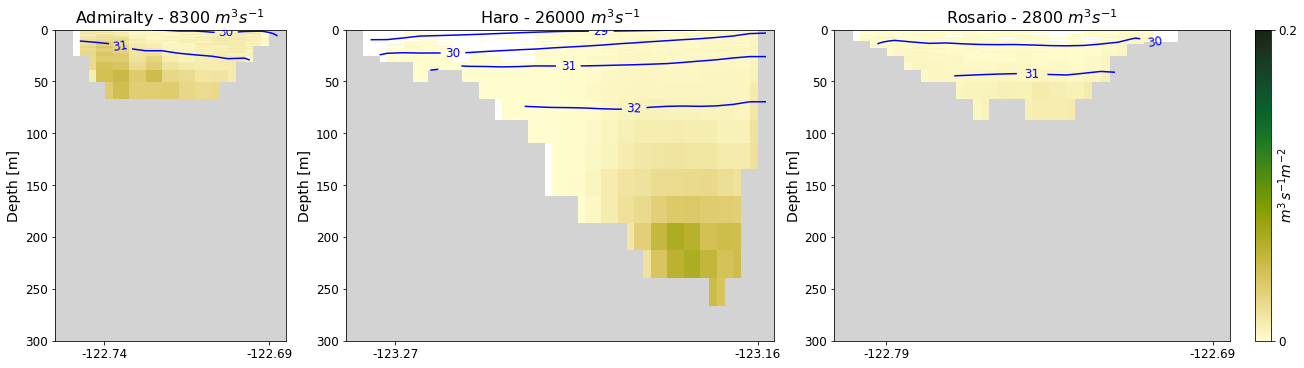

In [91]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 32, figure=fig)
ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:20])
ax2 = fig.add_subplot(gs[0, 20:])

high = 0.2
title = "Admiralty - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(upwelled.lon[upwelled.section == admiralty]), np.array(upwelled.depth[upwelled.section == admiralty]), np.array(upwelled.transport[upwelled.section == admiralty]), high, salS17, distlabel, False, title)
title = "Haro - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(upwelled.lon[upwelled.section == haro]), np.array(upwelled.depth[upwelled.section == haro]), np.array(upwelled.transport[upwelled.section == haro]), high, salS17, distlabel, False, title)
title = "Rosario - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(upwelled.lon[upwelled.section == rosario]), np.array(upwelled.depth[upwelled.section == rosario]), np.array(upwelled.transport[upwelled.section == rosario]), high, salS17, distlabel, True, title)

plt.savefig("./figures/InterChannelW16.pdf")

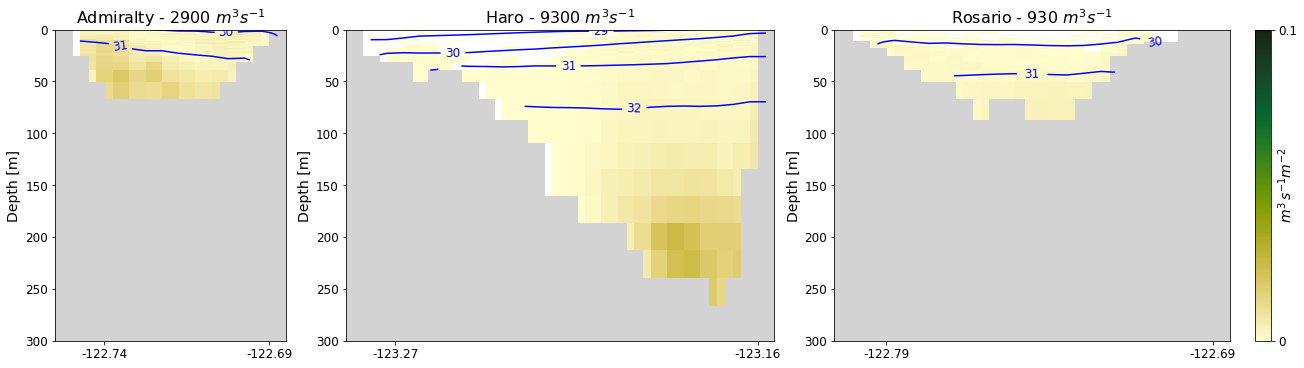

In [93]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 32, figure=fig)
ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:20])
ax2 = fig.add_subplot(gs[0, 20:])

high = 0.1
title = "Admiralty - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(cuc.lon[cuc.section == admiralty]), np.array(cuc.depth[cuc.section == admiralty]), np.array(cuc.transport[cuc.section == admiralty]), high, salS17, distlabel, False, title)
title = "Haro - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(cuc.lon[cuc.section == haro]), np.array(cuc.depth[cuc.section == haro]), np.array(cuc.transport[cuc.section == haro]), high, salS17, distlabel, False, title)
title = "Rosario - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(cuc.lon[cuc.section == rosario]), np.array(cuc.depth[cuc.section == rosario]), np.array(cuc.transport[cuc.section == rosario]), high, salS17, distlabel, True, title)

plt.savefig("./figures/DeepChannelW16.pdf")

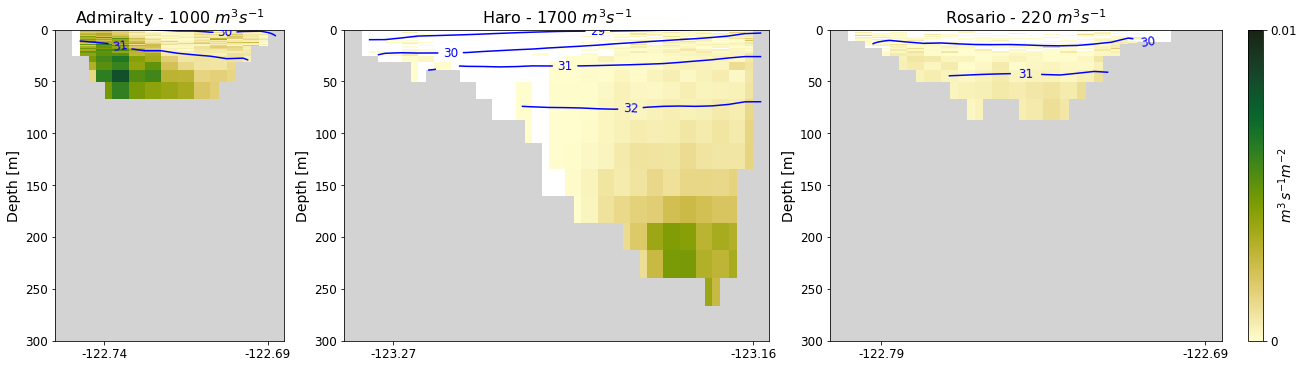

In [94]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 32, figure=fig)
ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:20])
ax2 = fig.add_subplot(gs[0, 20:])

high = 0.01
title = "Admiralty - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(columbia.lon[columbia.section == admiralty]), np.array(columbia.depth[columbia.section == admiralty]), np.array(columbia.transport[columbia.section == admiralty]), high, salS17, distlabel, False, title)
title = "Haro - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(columbia.lon[columbia.section == haro]), np.array(columbia.depth[columbia.section == haro]), np.array(columbia.transport[columbia.section == haro]), high, salS17, distlabel, False, title)
title = "Rosario - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(columbia.lon[columbia.section == rosario]), np.array(columbia.depth[columbia.section == rosario]), np.array(columbia.transport[columbia.section == rosario]), high, salS17, distlabel, True, title)

plt.savefig("./figures/PlumeChannelW16.pdf")

## Winter 2017/18

In [36]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
win_start = 1+(9*720+(sum(yearjumps[:9+1]*24)))
win_end = 720+(11*720+(sum(yearjumps[:11+1]*24)))

time = win_end-win_start+1+720*3

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt17, depth17, init_depth17, section17, trans17, init_trans17, lons17, initT17, finalT17 = get_data(mydata, win_start, win_end, time)

start = 1
end = 720

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_jan, depth_jan, init_depth_jan, section_jan, trans_jan, init_trans_jan, lons_jan, initTjan, finalTjan = get_data(mydata, start, end, time)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01feb18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_feb, depth_feb, init_depth_feb, section_feb, trans_feb, init_trans_feb, lons_feb, initTfeb, finalTfeb = get_data(mydata, start, end, time)

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt_mar, depth_mar, init_depth_mar, section_mar, trans_mar, init_trans_mar, lons_mar, initTmar, finalTmar = get_data(mydata, start, end, time)

salt = np.append(np.append(np.append(salt17, salt_jan), salt_feb), salt_mar)
# temp = np.append(np.append(np.append(temp17, temp_jan), temp_feb), temp_mar)
depth = np.append(np.append(np.append(depth17, depth_jan), depth_feb), depth_mar)
init_depth = np.append(np.append(np.append(init_depth17, init_depth_jan), init_depth_feb), init_depth_mar)
section = np.append(np.append(np.append(section17, section_jan), section_feb), section_mar)
trans = np.append(np.append(np.append(trans17, trans_jan), trans_feb), trans_mar)
init_trans = np.append(np.append(np.append(init_trans17, init_trans_jan), init_trans_feb), init_trans_mar)
lons = np.append(np.append(np.append(lons17, lons_jan), lons_feb), lons_mar)
initT = np.append(np.append(np.append(initT17, initTjan), initTfeb), initTmar)
finalT = np.append(np.append(np.append(finalT17, finalTjan), finalTfeb), finalTmar)

In [37]:
d = {'salt': salt, 'depth':depth, 'init_depth':init_depth, 'section':section, 'transport':trans, 'init_transport':init_trans, 'lon':lons, 'init_time':initT, 'final_time':finalT}
dfW17 = pd.DataFrame(data=d)

In [95]:
upwelled = dfW17[(dfW17.init_depth <= d) & (dfW17.salt >= 32)]
cuc = dfW17[(dfW17.init_depth > d) & (dfW17.salt >= 32)]
columbia = dfW17[(dfW17.init_depth <= d) & (dfW17.salt < 32)]

In [96]:
loop = dfW17[(dfW17.section == meander) & (abs(dfW17.final_time-dfW17.init_time) > 24)]
total_tr = np.sum([np.sum(dfW17.transport[dfW17.section==haro]),np.sum(dfW17.transport[dfW17.section==sanjuan]),np.sum(dfW17.transport[dfW17.section==rosario]),
           np.sum(dfW17.transport[dfW17.section==admiralty]),np.sum(dfW17.transport[dfW17.section==deception]),
           np.sum(dfW17.transport[(dfW17.section == meander) & (abs(dfW17.final_time-dfW17.init_time) > 24)])])
np.sum(loop.transport)/total_tr*100

64.46280504477593

In [97]:
[np.sum(upwelled.transport)/np.sum(dfW17.transport)*100,np.sum(cuc.transport)/np.sum(dfW17.transport)*100,
np.sum(columbia.transport)/np.sum(dfW17.transport)*100]

[46.20207737213554, 25.833828647373064, 27.964093980491416]

In [98]:
# lets see what sections these groups get into 
# first upwelled
tide = 24
tottran = np.sum(upwelled.transport) - np.sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time <= tide)])
print('tidally pumped = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time <= tide)])/np.sum(upwelled.transport)*100))
print('entrained and advects back out = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time > tide)])/tottran*100))
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/tottran*100))
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/tottran*100))
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/tottran*100))
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/tottran*100))
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/tottran*100))
print('\n')
print('tidally pumped = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time <= tide)])/10000) + ' mSv')
print('entrained and advects back out = ' + str(sum(upwelled.transport[(upwelled.section == meander) & (upwelled.final_time-upwelled.init_time > tide)])/10000) + ' mSv')
print('haro = ' + str(sum(upwelled.transport[upwelled.section == haro])/10000) + ' mSv')
print('sanjuan = ' + str(sum(upwelled.transport[upwelled.section == sanjuan])/10000) + ' mSv')
print('rosario = ' + str(sum(upwelled.transport[upwelled.section == rosario])/10000) + ' mSv')
print('admiralty = ' + str(sum(upwelled.transport[upwelled.section == admiralty])/10000) + ' mSv')
print('deception = ' + str(sum(upwelled.transport[upwelled.section == deception])/10000) + ' mSv')

tidally pumped = 65.22057479561238
entrained and advects back out = 55.37875911771497
haro = 27.600019366623396
sanjuan = 1.763620636389536
rosario = 2.7753158402771145
admiralty = 9.748758287691373
deception = 0.029445838763894703


tidally pumped = 16.041399675819285 mSv
entrained and advects back out = 4.7372167689686835 mSv
haro = 2.3609643236950824 mSv
sanjuan = 0.15086385801900684 mSv
rosario = 0.237406416236212 mSv
admiralty = 0.8339295060567902 mSv
deception = 0.0025188596384430103 mSv


In [99]:
# and deep
tottran = np.sum(cuc.transport) - np.sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time <= tide)])

print('tidally pumped = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time <= tide)])/np.sum(cuc.transport)*100))
print('entrained and advects back out = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time > tide)])/tottran*100))
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/tottran*100))
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/tottran*100))
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/tottran*100))
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/tottran*100))
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/tottran*100))
print('\n')
print('tidally pumped = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time <= tide)])/10000) + 'mSv')
print('entrained and advects back out = ' + str(sum(cuc.transport[(cuc.section == meander) & (cuc.final_time-cuc.init_time > tide)])/10000) + 'mSv')
print('haro = ' + str(sum(cuc.transport[cuc.section == haro])/10000) + 'mSv')
print('sanjuan = ' + str(sum(cuc.transport[cuc.section == sanjuan])/10000) + 'mSv')
print('rosario = ' + str(sum(cuc.transport[cuc.section == rosario])/10000) + 'mSv')
print('admiralty = ' + str(sum(cuc.transport[cuc.section == admiralty])/10000) + 'mSv')
print('deception = ' + str(sum(cuc.transport[cuc.section == deception])/10000) + 'mSv')

tidally pumped = 70.63061288888962
entrained and advects back out = 66.61906675988652
haro = 20.782619806821963
sanjuan = 1.186303284013481
rosario = 2.062028398999597
admiralty = 6.706982304761879
deception = 0.025467532628531835


tidally pumped = 9.713547850478577mSv
entrained and advects back out = 2.690780906329946mSv
haro = 0.8394214941687415mSv
sanjuan = 0.04791544494679173mSv
rosario = 0.08328646608539902mSv
admiralty = 0.2708987201786015mSv
deception = 0.0010286477109500878mSv


In [100]:
# columbia 
tottran = np.sum(columbia.transport) - np.sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time <= tide)])

print('tidally pumped = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time <= tide)])/np.sum(columbia.transport)*100))
print('entrained and advects back out = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time > tide)])/tottran*100))
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/tottran*100))
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/tottran*100))
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/tottran*100))
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/tottran*100))
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/tottran*100))
print('\n')
print('tidally pumped = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time <= tide)])/10000)+' mSv')
print('entrained and advects back out = ' + str(sum(columbia.transport[(columbia.section == meander) & (columbia.final_time-columbia.init_time > tide)])/10000)+' mSv')
print('haro = ' + str(sum(columbia.transport[columbia.section == haro])/10000)+' mSv')
print('sanjuan = ' + str(sum(columbia.transport[columbia.section == sanjuan])/10000)+' mSv')
print('rosario = ' + str(sum(columbia.transport[columbia.section == rosario])/10000)+' mSv')
print('admiralty = ' + str(sum(columbia.transport[columbia.section == admiralty])/10000)+' mSv')
print('deception = ' + str(sum(columbia.transport[columbia.section == deception])/10000)+' mSv')

tidally pumped = 83.67703071752108
entrained and advects back out = 83.35037591634035
haro = 7.730870684262896
sanjuan = 0.5870671978875013
rosario = 1.063077825123061
admiralty = 6.373096987212831
deception = 0.01734263808639534


tidally pumped = 12.456704103535408 mSv
entrained and advects back out = 2.0253664596020156 mSv
haro = 0.18785573568549346 mSv
sanjuan = 0.014265397115033081 mSv
rosario = 0.025832183085916928 mSv
admiralty = 0.1548626114733697 mSv
deception = 0.00042141618577050134 mSv


In [101]:
distlabel = True

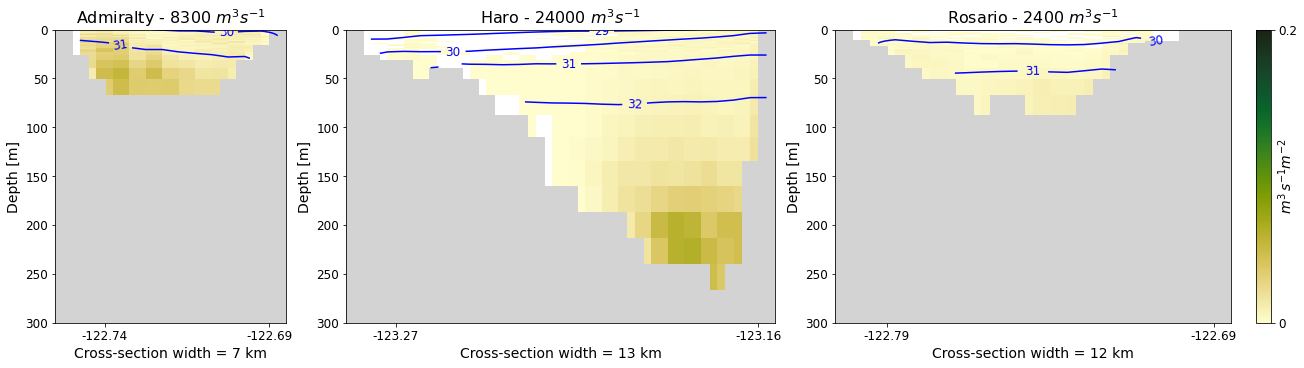

In [102]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 32, figure=fig)
ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:20])
ax2 = fig.add_subplot(gs[0, 20:])

high = 0.2
title = "Admiralty - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(upwelled.lon[upwelled.section == admiralty]), np.array(upwelled.depth[upwelled.section == admiralty]), np.array(upwelled.transport[upwelled.section == admiralty]), high, salS17, distlabel, False, title)
title = "Haro - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(upwelled.lon[upwelled.section == haro]), np.array(upwelled.depth[upwelled.section == haro]), np.array(upwelled.transport[upwelled.section == haro]), high, salS17, distlabel, False, title)
title = "Rosario - "+ str(round_to_2(np.sum(upwelled.transport[upwelled.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(upwelled.lon[upwelled.section == rosario]), np.array(upwelled.depth[upwelled.section == rosario]), np.array(upwelled.transport[upwelled.section == rosario]), high, salS17, distlabel, True, title)

plt.savefig("./figures/InterChannelW17.pdf")

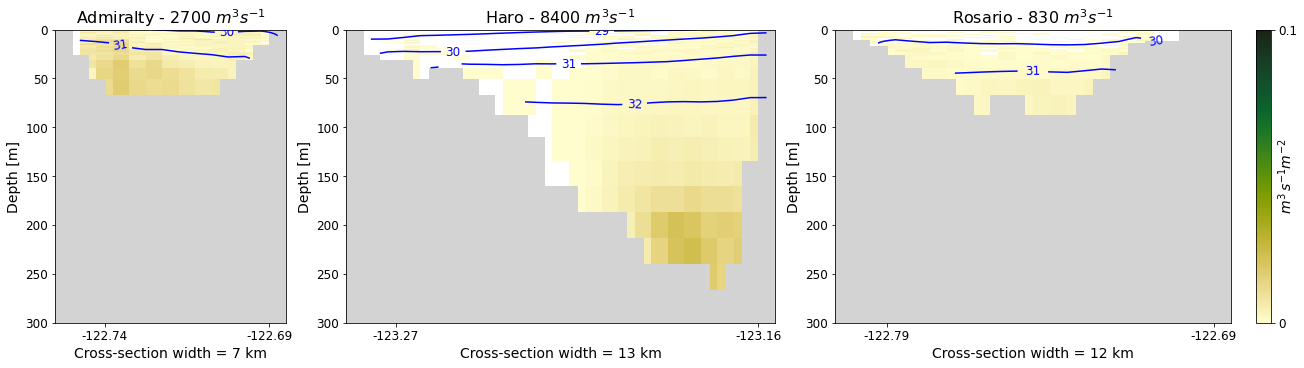

In [104]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 32, figure=fig)
ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:20])
ax2 = fig.add_subplot(gs[0, 20:])

high = 0.1
title = "Admiralty - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(cuc.lon[cuc.section == admiralty]), np.array(cuc.depth[cuc.section == admiralty]), np.array(cuc.transport[cuc.section == admiralty]), high, salS17, distlabel, False, title)
title = "Haro - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(cuc.lon[cuc.section == haro]), np.array(cuc.depth[cuc.section == haro]), np.array(cuc.transport[cuc.section == haro]), high, salS17, distlabel, False, title)
title = "Rosario - "+ str(round_to_2(np.sum(cuc.transport[cuc.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(cuc.lon[cuc.section == rosario]), np.array(cuc.depth[cuc.section == rosario]), np.array(cuc.transport[cuc.section == rosario]), high, salS17, distlabel, True, title)

plt.savefig("./figures/DeepChannelW17.pdf")

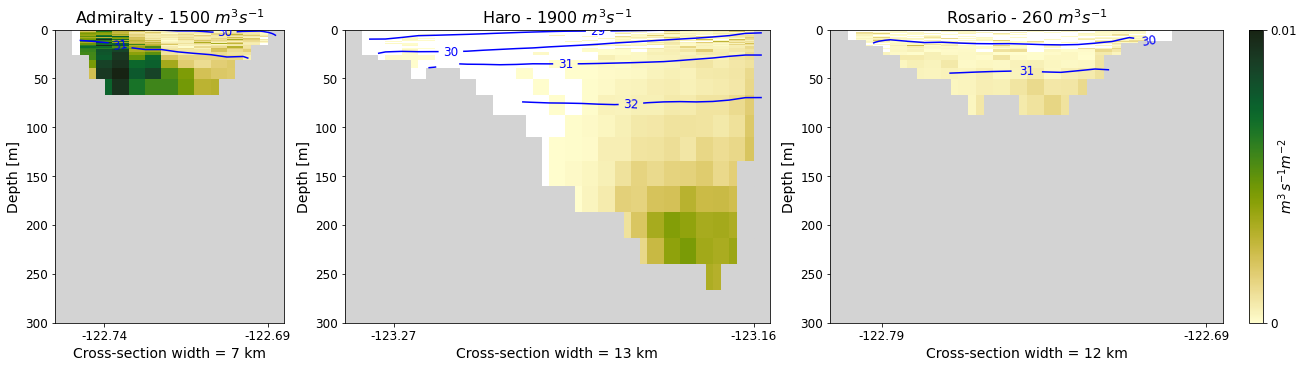

In [106]:
fig = plt.figure(constrained_layout=True, figsize=[18,5])
gs = GridSpec(1, 32, figure=fig)
ax0 = fig.add_subplot(gs[0, :7])
ax1 = fig.add_subplot(gs[0, 7:20])
ax2 = fig.add_subplot(gs[0, 20:])

high = 0.01
title = "Admiralty - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == admiralty])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSadmiralty[1], CSadmiralty[2], CSadmiralty[3], CSadmiralty[4], ax0, np.array(columbia.lon[columbia.section == admiralty]), np.array(columbia.depth[columbia.section == admiralty]), np.array(columbia.transport[columbia.section == admiralty]), high, salS17, distlabel, False, title)
title = "Haro - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == haro])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSharo[1], CSharo[2], CSharo[3], CSharo[4], ax1, np.array(columbia.lon[columbia.section == haro]), np.array(columbia.depth[columbia.section == haro]), np.array(columbia.transport[columbia.section == haro]), high, salS17, distlabel, False, title)
title = "Rosario - "+ str(round_to_2(np.sum(columbia.transport[columbia.section == rosario])))[:-2] + " $m^3 s^{-1}$"
FluxCS(CSrosario[1], CSrosario[2], CSrosario[3], CSrosario[4], ax2, np.array(columbia.lon[columbia.section == rosario]), np.array(columbia.depth[columbia.section == rosario]), np.array(columbia.transport[columbia.section == rosario]), high, salS17, distlabel, True, title)

plt.savefig("./figures/PlumeChannelW17.pdf")

# plots of water masses to straits or meander?

In [11]:
starttime = 1
endtime = 720
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
d = 150

freshSOG = np.array([])
freshPS = np.array([])
    
cucSOG = np.array([])
cucPS = np.array([])
    
upSOG = np.array([])
upPS = np.array([])
SoG = np.array([])
PS = np.array([])


#216 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        start, end = starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24)))
        
        XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))
                                          & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                         & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        
        XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)),(mydata.final_section==sanjuan))
                                               & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                              & (mydata.init_salt < 32) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))
                                             & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                            & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))
                                            & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                           & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
          
        freshSOG = np.append(freshSOG, XfreshSOG)
        freshPS = np.append(freshPS, XfreshPS)

        cucSOG = np.append(cucSOG, XcucSOG)
        cucPS = np.append(cucPS, XcucPS)

        upSOG = np.append(upSOG, XupSOG)
        upPS = np.append(upPS, XupPS)
    
        SoG = np.append(SoG, XSOG)
        PS = np.append(PS, XPS)
            

#2019 and 2018 (both done month by month)
year = [18,19]
str_mo = ['jan', 'feb', 'mar', 'apr', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        start, end = 1, 720
        
        XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))])/720
        XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))])/720
        
        XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))
                                               & (mydata.init_salt < 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                              & (mydata.init_salt < 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))
                                             & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                            & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

        XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))
                                            & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                           & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
            
        freshSOG = np.append(freshSOG, XfreshSOG)
        freshPS = np.append(freshPS, XfreshPS)

        cucSOG = np.append(cucSOG, XcucSOG)
        cucPS = np.append(cucPS, XcucPS)

        upSOG = np.append(upSOG, XupSOG)
        upPS = np.append(upPS, XupPS)
    
        SoG = np.append(SoG, XSOG)
        PS = np.append(PS, XPS)
        
#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    start, end = starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24)))
        
    XSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))
                                      & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                     & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
        
    XfreshSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))
                                           & (mydata.init_salt < 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XfreshPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                          & (mydata.init_salt < 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

    XcucSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))
                                         & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XcucPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                        & (mydata.init_salt >= 32) & (mydata.init_depth < -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720

    XupSOG = np.sum(mydata.final_transp[np.logical_or(np.logical_or((mydata.final_section==haro),(mydata.final_section==rosario)), (mydata.final_section==sanjuan))
                                        & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
    XupPS = np.sum(mydata.final_transp[np.logical_or((mydata.final_section==admiralty),(mydata.final_section==deception))
                                       & (mydata.init_salt >= 32) & (mydata.init_depth >= -d) & (mydata.init_t >= start) & (mydata.init_t <= end)])/720
            
    freshSOG = np.append(freshSOG, XfreshSOG)
    freshPS = np.append(freshPS, XfreshPS)

    cucSOG = np.append(cucSOG, XcucSOG)
    cucPS = np.append(cucPS, XcucPS)

    upSOG = np.append(upSOG, XupSOG)
    upPS = np.append(upPS, XupPS)
    
    SoG = np.append(SoG, XSOG)
    PS = np.append(PS, XPS)

In [12]:
dates = np.array([dt.datetime(2016,1,1)+ relativedelta(months=+i)for i in range(len(upPS))])

In [66]:
# fig, ax = plt.subplots(3,1,figsize=(10,15))

# ax[0].plot(dates, freshSOG, 'r')#, ls='dotted')
# # ax[0].plot(dates, freshOUT, 'k')#, ls='dotted')
# ax[0].plot(dates, freshPS, 'b')#, ls='dotted')
# # ax[0].set_yscale('log')

# ax[1].plot(dates, cucSOG, 'r')
# # ax[1].plot(dates, cucOUT, 'k')
# ax[1].plot(dates, cucPS, 'b')
# # ax[1].set_yscale('log')

# ax[2].plot(dates, upSOG, 'r')
# # ax[2].plot(dates, upOUT, 'k')
# ax[2].plot(dates, upPS, 'b')
# # ax[2].set_yscale('log')

In [13]:
# lets calculate the peason's correlation coefficient 
sg_up, _ = pearsonr(SoG, upSOG)
sg_cuc, _ = pearsonr(SoG, cucSOG)
sg_fresh, _ = pearsonr(SoG, freshSOG)

ps_up, _ = pearsonr(PS, upPS)
ps_cuc, _ = pearsonr(PS, cucPS)
ps_fresh, _ = pearsonr(PS, freshPS)

In [14]:
season = [pd.to_datetime('2016-04-01'), pd.to_datetime('2016-09-01'),
 pd.to_datetime('2017-05-01'),pd.to_datetime('2017-10-01'),
 pd.to_datetime('2018-03-01'),pd.to_datetime('2018-09-01'),
 pd.to_datetime('2019-04-01'),pd.to_datetime('2019-11-01'),
 pd.to_datetime('2020-03-01'),pd.to_datetime('2020-10-01')]

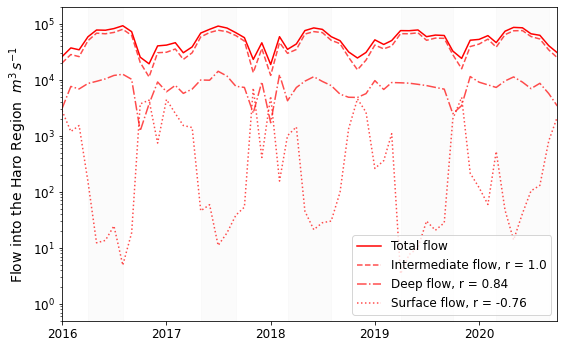

In [16]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(dates, SoG, c='r', label='Total flow')
ax.plot(dates, upSOG, c='r', alpha = 0.7, label = 'Intermediate flow, r = '+str(np.round(sg_up,2)), ls='dashed')
ax.plot(dates, cucSOG, c='r', alpha = 0.7, label='Deep flow, r = '+str(np.round(sg_cuc,2)), ls='dashdot')
ax.plot(dates, freshSOG, c='r', alpha = 0.7, label='Surface flow, r = '+str(np.round(sg_fresh,2)), ls='dotted')
ax.set_yscale('log')
ax.set_ylabel('Flow into the Haro Region  $m^3\,s^{-1}$', fontsize=14)
ax.set_xticks([dates[i] for i in [0,12,24,36,48]])
ax.set_xticklabels([2016,2017,2018,2019,2020],fontsize=12)
ax.legend(loc='lower right',fontsize=12)
ax.set_ylim([0.5,200000])
ax.set_xlim([dates[0],dates[-1]])

for i in range(0, len(season),2):
    ax.fill_between(dates, 0.5,200000, where=(dates<season[i+1])&(dates>=season[i]), color='whitesmoke', alpha=0.4)
#     ax[1].fill_between(dates, 0.5,200000, where=(dates<season[i+1])&(dates>=season[i]), color='whitesmoke', alpha=0.4)
plt.tight_layout()

plt.savefig("./figures/WMfluxHaro.pdf")


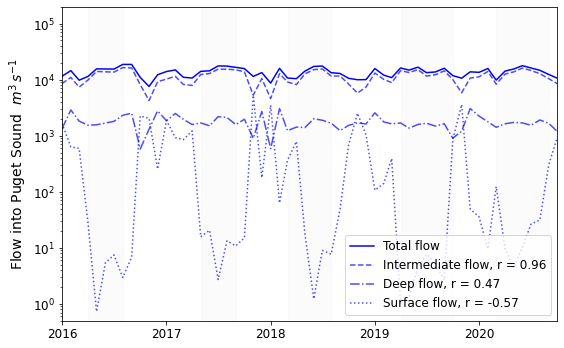

In [18]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(dates, PS, c='b', label='Total flow')
ax.plot(dates, upPS, c='b', alpha = 0.7, label = 'Intermediate flow, r = '+str(np.round(ps_up,2)), ls='dashed')
ax.plot(dates, cucPS, c='b', alpha = 0.7, label='Deep flow, r = '+str(np.round(ps_cuc,2)), ls='dashdot')
ax.plot(dates, freshPS, c='b', alpha = 0.7, label='Surface flow, r = '+str(np.round(ps_fresh,2)), ls='dotted')
ax.set_yscale('log')
ax.set_ylabel('Flow into Puget Sound  $m^3\,s^{-1}$', fontsize=14)
ax.set_xticks([dates[i] for i in [0,12,24,36,48]])
ax.set_xticklabels([2016,2017,2018,2019,2020],fontsize=12)
ax.legend(loc='lower right',fontsize=12)
ax.set_ylim([0.5,200000])
ax.set_xlim([dates[0],dates[-1]])


for i in range(0, len(season),2):
    ax.fill_between(dates, 0.5,200000, where=(dates<season[i+1])&(dates>=season[i]), color='whitesmoke', alpha=0.4)
#     ax[1].fill_between(dates, 0.5,200000, where=(dates<season[i+1])&(dates>=season[i]), color='whitesmoke', alpha=0.4)
plt.tight_layout()

plt.savefig("./figures/WMfluxPuget.pdf")


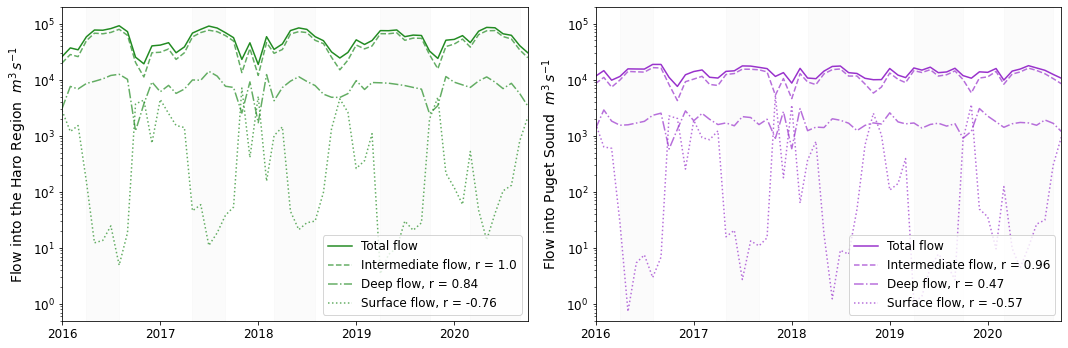

In [69]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(dates, SoG, c='forestgreen', label='Total flow')
ax[0].plot(dates, upSOG, c='forestgreen', alpha = 0.7, label = 'Intermediate flow, r = '+str(np.round(sg_up,2)), ls='dashed')
ax[0].plot(dates, cucSOG, c='forestgreen', alpha = 0.7, label='Deep flow, r = '+str(np.round(sg_cuc,2)), ls='dashdot')
ax[0].plot(dates, freshSOG, c='forestgreen', alpha = 0.7, label='Surface flow, r = '+str(np.round(sg_fresh,2)), ls='dotted')
ax[0].set_yscale('log')
ax[0].set_ylabel('Flow into the Haro Region  $m^3\,s^{-1}$', fontsize=14)
ax[0].set_xticks([dates[i] for i in [0,12,24,36,48]])
ax[0].set_xticklabels([2016,2017,2018,2019,2020],fontsize=12)
ax[0].legend(loc='lower right',fontsize=12)
ax[0].set_ylim([0.5,200000])
ax[0].set_xlim([dates[0],dates[-1]])

ax[1].plot(dates, PS, c='darkorchid', label='Total flow')
ax[1].plot(dates, upPS, c='darkorchid', alpha = 0.7, label = 'Intermediate flow, r = '+str(np.round(ps_up,2)), ls='dashed')
ax[1].plot(dates, cucPS, c='darkorchid', alpha = 0.7, label='Deep flow, r = '+str(np.round(ps_cuc,2)), ls='dashdot')
ax[1].plot(dates, freshPS, c='darkorchid', alpha = 0.7, label='Surface flow, r = '+str(np.round(ps_fresh,2)), ls='dotted')
ax[1].set_yscale('log')
ax[1].set_ylabel('Flow into Puget Sound  $m^3\,s^{-1}$', fontsize=14)
ax[1].set_xticks([dates[i] for i in [0,12,24,36,48]])
ax[1].set_xticklabels([2016,2017,2018,2019,2020],fontsize=12)
ax[1].legend(loc='lower right',fontsize=12)
ax[1].set_ylim([0.5,200000])
ax[1].set_xlim([dates[0],dates[-1]])


for i in range(0, len(season),2):
    ax[0].fill_between(dates, 0.5,200000, where=(dates<season[i+1])&(dates>=season[i]), color='whitesmoke', alpha=0.4)
    ax[1].fill_between(dates, 0.5,200000, where=(dates<season[i+1])&(dates>=season[i]), color='whitesmoke', alpha=0.4)
plt.tight_layout()
# plt.savefig("./figures/WMflux.pdf")

# ax[0].fill_between(dates, 0.5,200000, where=(dates<dates[3+1]), color='whitesmoke', alpha=0.4)
# ax[0].fill_between(dates, 0.5,200000, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
# ax[0].fill_between(dates, 0.5,200000, where=(dates<dates[21+1])&(dates>=dates[15]), color='whitesmoke', alpha=0.4)
# ax[0].fill_between(dates, 0.5,200000, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
# ax[0].fill_between(dates, 0.5,200000, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)

# ax[1].fill_between(dates, 0.5,200000, where=(dates<dates[9+1])&(dates>=dates[3]), color='whitesmoke', alpha=0.4)
# ax[1].fill_between(dates, 0.5,200000, where=(dates<dates[21+1])&(dates>=dates[15]), color='whitesmoke', alpha=0.4)
# ax[1].fill_between(dates, 0.5,200000, where=(dates<dates[33+1])&(dates>=dates[27]), color='whitesmoke', alpha=0.4)
# ax[1].fill_between(dates, 0.5,200000, where=(dates<dates[45+1])&(dates>=dates[39]), color='whitesmoke', alpha=0.4)